<a href="https://colab.research.google.com/github/midnightripper/accuracy_improvement/blob/main/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Prerequisite

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Reshape
from tensorflow.keras import backend as K

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Load the train and test data splits

In [4]:
GER_test = (np.array(sio.loadmat('/content/drive/MyDrive/training data/GER_test.mat')['GER_test'])).transpose()
GER_train = (np.array(sio.loadmat('/content/drive/MyDrive/training data/GER_train.mat')['GER_train'])).transpose()
test_frame = pd.DataFrame(GER_test).sort_values(1)
train_frame = pd.DataFrame(GER_train).sort_values(1)

In [5]:
print(f"x_train shape: {GER_train.shape} - y_train shape: {GER_train.shape}")
print(f"x_test shape: {GER_test.shape} - y_test shape: {GER_test.shape}")

x_train shape: (6981, 21) - y_train shape: (6981, 21)
x_test shape: (6248, 21) - y_test shape: (6248, 21)


In [6]:
def get_data_labels(split):
    x = pd.DataFrame(split)
    labels = x[0].values.astype(np.uint8)
    del x[0],x[1]
    data = x.values 
    return data, labels
    
x_train, y_train = get_data_labels(train_frame.values.tolist())
x_test, y_test = get_data_labels(test_frame.values.tolist())

In [7]:
df = pd.DataFrame(x_train)
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [8]:
df2 = pd.DataFrame(x_test)
scaler = StandardScaler()
x_test = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns)

In [9]:
input_shape = (19,)

In [10]:
# Define the sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], 8), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

# def sampling(args):
#     """Reparameterization trick. Instead of sampling from Q(z|X), 
#     sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

#     Parameters:
#     -----------
#     args: list of Tensors
#         Mean and log of variance of Q(z|X)

#     Returns
#     -------
#     z: Tensor
#         Sampled latent vector
#     """

#     z_mean, z_log_var = args
#     eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
#     z = z_mean + tf.exp(z_log_var / 2) * eps
#     return z

In [11]:
inputs = keras.layers.Input(shape=input_shape, name='input')
x = keras.layers.Dense(12, activation='relu')(inputs)
z_mean = keras.layers.Dense(8, name='z_mean')(x)
z_log_var = keras.layers.Dense(8, name='z_log_var')(x)

In [12]:
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12)           240         ['input[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 8)            104         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 8)            104         ['dense[0][0]']                  
                                                                                            

In [13]:
# z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

In [14]:
latent_inputs = keras.layers.Input(shape=(8), name='z_sampling')
x = keras.layers.Dense(12, activation='relu')(latent_inputs)
outputs = keras.layers.Dense(19, activation='sigmoid')(x)

# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dense_2 (Dense)             (None, 19)                247       
                                                                 
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________


In [15]:
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 19)]              0         
                                                                 
 encoder (Functional)        [(None, 8),               448       
                              (None, 8),                         
                              (None, 8)]                         
                                                                 
 decoder (Functional)        (None, 19)                355       
                                                                 
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________


In [16]:
encoder = Model(inputs, z_mean)
autoencoder = Model(inputs, outputs)

In [17]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = reconstruction_loss * 19

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='adam')
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 8),          448         ['input[0][0]']                  
                                 (None, 8),                                                       
                                 (None, 8)]                                                       
                                                                                                  
 decoder (Functional)           (None, 19)           355         ['encoder[0][2]']                
                                                                                            

In [20]:
autoencoder.fit(x_train, epochs=50, batch_size=265, validation_data=(x_test, None))

Epoch 1/50
27/27 [==============================] - 9s 14ms/step - loss: 15.2487 - val_loss: 13.2361
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 11.7186 - val_loss: 10.1414
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: 8.4432 - val_loss: 6.3279
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 3.1659 - val_loss: -0.6804
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: -7.3254 - val_loss: -15.6911
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: -29.5509 - val_loss: -47.9234
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: -77.4467 - val_loss: -114.8491
Epoch 8/50
27/27 [==============================] - 0s 7ms/step - loss: -172.1073 - val_loss: -247.4728
Epoch 9/50
27/27 [==============================] - 0s 7ms/step - loss: -348.6668 - val_loss: -479.6708
Epoch 10/50
27/27 [==============================] - 0s 6ms/step - loss: -651.7640 - val

In [21]:
encoder = Model(inputs, z)
encoder.trainable = False
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12)           240         ['input[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 8)            104         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 8)            104         ['dense[0][0]']                  
                                                                                            

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from keras.models import Model
import seaborn as sns

219/219 [==============================] - 0s 1ms/step
(6981, 8)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6981 samples in 0.006s...
[t-SNE] Computed neighbors for 6981 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6981
[t-SNE] Computed conditional probabilities for sample 2000 / 6981
[t-SNE] Computed conditional probabilities for sample 3000 / 6981
[t-SNE] Computed conditional probabilities for sample 4000 / 6981
[t-SNE] Computed conditional probabilities for sample 5000 / 6981
[t-SNE] Computed conditional probabilities for sample 6000 / 6981
[t-SNE] Computed conditional probabilities for sample 6981 / 6981
[t-SNE] Mean sigma: 2.755905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.560730
[t-SNE] KL divergence after 1000 iterations: 0.539035


<ipython-input-24-87cab7423bba>:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Encoder T-SNE projection')]

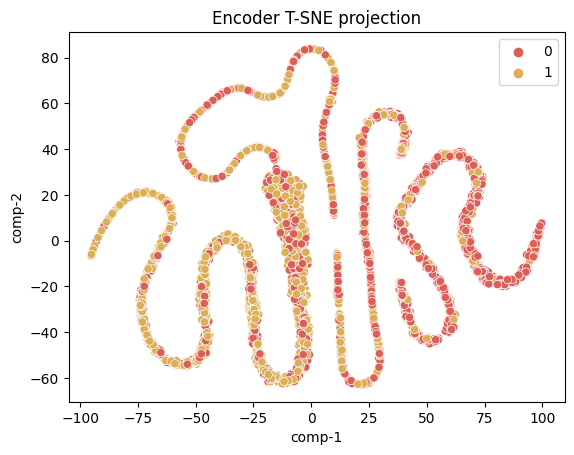

In [24]:
encoded_data = encoder.predict(x_train)
print(encoded_data.shape)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(encoded_data)
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Encoder T-SNE projection")

219/219 [==============================] - 0s 2ms/step
(6981, 19)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6981 samples in 0.001s...
[t-SNE] Computed neighbors for 6981 samples in 0.456s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6981
[t-SNE] Computed conditional probabilities for sample 2000 / 6981
[t-SNE] Computed conditional probabilities for sample 3000 / 6981
[t-SNE] Computed conditional probabilities for sample 4000 / 6981
[t-SNE] Computed conditional probabilities for sample 5000 / 6981
[t-SNE] Computed conditional probabilities for sample 6000 / 6981
[t-SNE] Computed conditional probabilities for sample 6981 / 6981
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.960808
[t-SNE] KL divergence after 1000 iterations: 0.530342


<ipython-input-25-573fe2a90b52>:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Autoencoder T-SNE projection')]

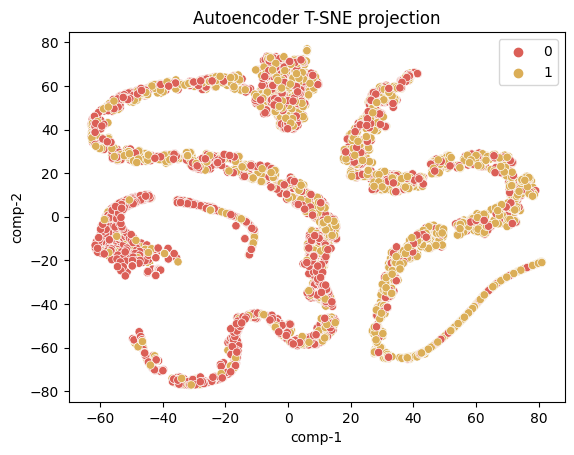

In [25]:
encoded_data = autoencoder.predict(x_train)
print(encoded_data.shape)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(encoded_data)
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Autoencoder T-SNE projection")

In [22]:
classifier_input = Input(shape=(19,))
encoded_input = encoder(classifier_input)
x1=Dense(128,activation='relu')(encoded_input)
x2=Dense(64,activation='relu')(x1)
x3=Dense(32,activation='relu')(x2)
x4=Dense(16,activation='relu')(x3)
x5=Dense(8,activation='relu')(x4)
x6=Dense(4,activation='relu')(x5)
output_layer = Dense(1, activation='sigmoid')(x6)

classifier = Model(classifier_input, output_layer)
classifier.summary()
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 model_2 (Functional)        (None, 8)                 448       
                                                                 
 dense_3 (Dense)             (None, 128)               1152      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136 

In [26]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

196/196 [==============================] - 1s 4ms/step - loss: 0.6137 - accuracy: 0.6831
Test accuracy: 68.31%


In [27]:
accuracy = classifier.evaluate(x_train, y_train)[1]
print(f"Train accuracy: {round(accuracy * 100, 2)}%")

219/219 [==============================] - 1s 3ms/step - loss: 0.6203 - accuracy: 0.6784
Train accuracy: 67.84%
